# Imports

In [42]:
import os
import sys
import json
import spotipy
import webbrowser
import spotipy.util as util
from json.decoder import JSONDecodeError
from collections import OrderedDict
import pickle
from __future__ import print_function, division
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot
import pylab
import patsy
%matplotlib inline
%config InlineBackend.figure_format='svg'
import scipy
import statsmodels
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.cross_validation import KFold
from sklearn.metrics import mean_squared_error as MSE
from sklearn.linear_model import Lasso
import datetime as dt
from sklearn import datasets, linear_model

# Clean data

In [43]:
with open('final.pkl', 'rb') as handle:
    data = pickle.load(handle)
data.head()

,artist,followers,popularity,spotify_artist_id,albums
0,Kendrick Lamar,8813295,94,2YZyLoL8N0Wb9xBt1NhZWg,DAMN.
1,Kendrick Lamar,8813295,94,2YZyLoL8N0Wb9xBt1NhZWg,DAMN. COLLECTORS EDITION.
2,Kendrick Lamar,8813295,94,2YZyLoL8N0Wb9xBt1NhZWg,Overly Dedicated
3,Kendrick Lamar,8813295,94,2YZyLoL8N0Wb9xBt1NhZWg,"King's Dead (with Kendrick Lamar, Future & Jam..."
4,Kendrick Lamar,8813295,94,2YZyLoL8N0Wb9xBt1NhZWg,"good kid, m.A.A.d city (Deluxe)"


In [44]:
data.dtypes

artist               object
followers            object
popularity            int64
spotify_artist_id    object
albums               object
dtype: object

In [45]:
data['followers'] = data['followers'].astype(int)

In [46]:
data.dtypes

artist               object
followers             int64
popularity            int64
spotify_artist_id    object
albums               object
dtype: object

# EDA 

In [47]:
data.head()

,artist,followers,popularity,spotify_artist_id,albums
0,Kendrick Lamar,8813295,94,2YZyLoL8N0Wb9xBt1NhZWg,DAMN.
1,Kendrick Lamar,8813295,94,2YZyLoL8N0Wb9xBt1NhZWg,DAMN. COLLECTORS EDITION.
2,Kendrick Lamar,8813295,94,2YZyLoL8N0Wb9xBt1NhZWg,Overly Dedicated
3,Kendrick Lamar,8813295,94,2YZyLoL8N0Wb9xBt1NhZWg,"King's Dead (with Kendrick Lamar, Future & Jam..."
4,Kendrick Lamar,8813295,94,2YZyLoL8N0Wb9xBt1NhZWg,"good kid, m.A.A.d city (Deluxe)"


In [48]:
data.shape

(765, 5)

## Create a dataframe with spotify_artist_id and albums

In [49]:
df = data.drop(columns=['spotify_artist_id','albums'])
df = df.drop_duplicates(subset=['artist'],keep='first')
df.head()

,artist,followers,popularity
0,Kendrick Lamar,8813295,94
0,Travis Scott,2627425,90
0,Migos,5268541,91
0,Jaden Smith,379461,74
0,Rich Brian,622901,74


In [50]:
df.shape

(52, 3)

## Pairplots and correlation matrixes

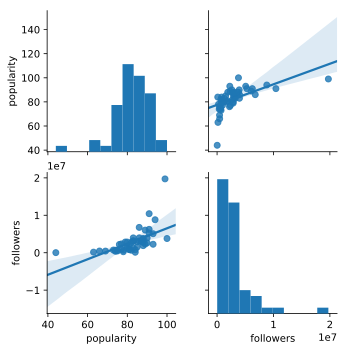

In [51]:
sns.pairplot(df, vars=['popularity', 'followers'], kind='reg');

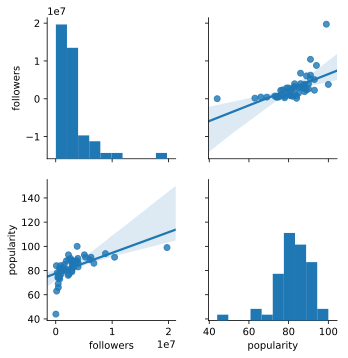

In [52]:
sns.pairplot(df, vars=['followers', 'popularity'], kind='reg');

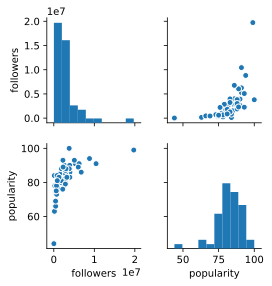

In [53]:
sns.pairplot(df, size = 2, aspect=1);

### Log followers and popularity

In [54]:
df['followers_log']=np.log(df.followers)
df['popularity_log']=np.log(df.popularity)

In [55]:
df.head()

,artist,followers,popularity,followers_log,popularity_log
0,Kendrick Lamar,8813295,94,15.991772,4.543295
0,Travis Scott,2627425,90,14.781515,4.499810
0,Migos,5268541,91,15.477264,4.510860
0,Jaden Smith,379461,74,12.846507,4.304065
0,Rich Brian,622901,74,13.342143,4.304065


## Pairplots and correlation matrixes Part 2

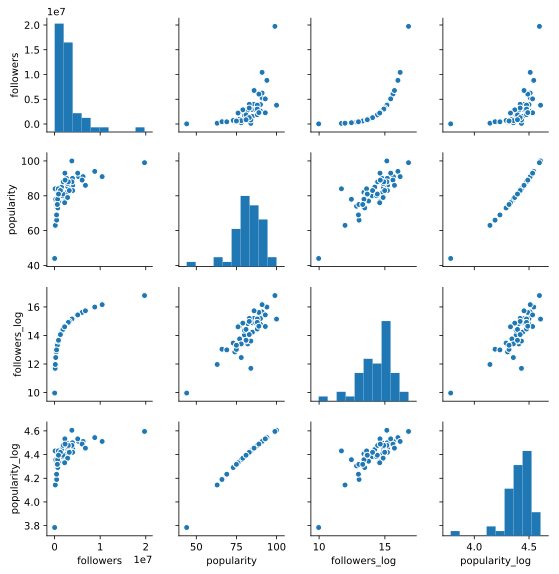

In [56]:
sns.pairplot(df, size = 2, aspect=1);

In [57]:
df.corr()

,followers,popularity,followers_log,popularity_log
followers,1.000000,0.593982,0.737934,0.536734
popularity,0.593982,1.000000,0.827519,0.989912
followers_log,0.737934,0.827519,1.000000,0.822557
popularity_log,0.536734,0.989912,0.822557,1.000000


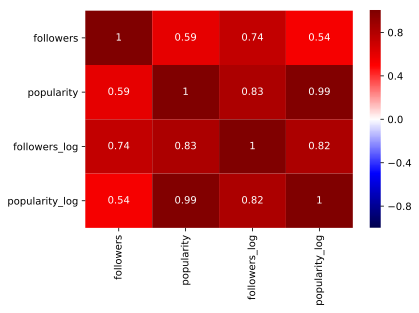

In [58]:
sns.heatmap(df.corr(), cmap='seismic',vmin=-1,vmax=1, annot=True);

# OLS and Linear Regression

In [59]:
df.head()

,artist,followers,popularity,followers_log,popularity_log
0,Kendrick Lamar,8813295,94,15.991772,4.543295
0,Travis Scott,2627425,90,14.781515,4.499810
0,Migos,5268541,91,15.477264,4.510860
0,Jaden Smith,379461,74,12.846507,4.304065
0,Rich Brian,622901,74,13.342143,4.304065


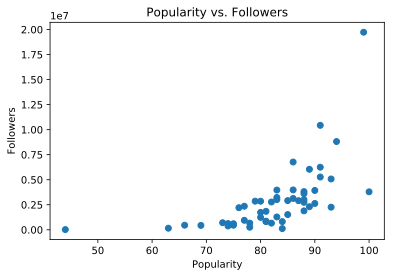

In [60]:
x = df.followers
y = df.popularity
plt.title("Popularity vs. Followers")
plt.xlabel("Popularity")
plt.ylabel("Followers")
matplotlib.pyplot.scatter(y,x)
matplotlib.pyplot.show()

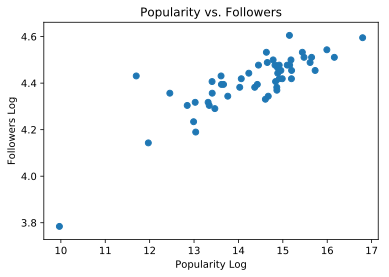

In [61]:
x = df.popularity_log
y = df.followers_log
plt.title("Popularity vs. Followers")
plt.xlabel("Popularity Log")
plt.ylabel("Followers Log")
matplotlib.pyplot.scatter(y,x)
matplotlib.pyplot.show()

In [62]:
y, X = patsy.dmatrices('followers ~ popularity', data=df, return_type="dataframe")

# Create model
model_1 = sm.OLS(y,X)
# This model fits the whole model to my as my training set
fit_1 = model_1.fit()
# Print summary statistics of the model's performance
fit_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              followers   R-squared:                       0.353
Model:                            OLS   Adj. R-squared:                  0.340
Method:                 Least Squares   F-statistic:                     27.26
Date:                Tue, 08 May 2018   Prob (F-statistic):           3.45e-06
Time:                        22:54:39   Log-Likelihood:                -841.54
No. Observations:                  52   AIC:                             1687.
Df Residuals:                      50   BIC:                             1691.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.417e+07   3.29e+06     -4.305      0.000   -2.08e+07   -7.56e+06
popularity   2.07e+05   3.96e+04      5.221      0.000    1.27e+05    2.87e+05
==============================================================================
Omnibus:                       58.816   Durbin-Watson:                   2.046
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              388.522
Skew:                           2.971   Prob(JB):                     4.30e-85
Kurtosis:                      15.000   Cond. No.                         748.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [63]:
y, X = patsy.dmatrices('followers_log ~ popularity_log', data=df, return_type="dataframe")

# Create model
model_1 = sm.OLS(y,X)
# This model fits the whole model to my as my training set
fit_1 = model_1.fit()
# Print summary statistics of the model's performance
fit_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          followers_log   R-squared:                       0.677
Model:                            OLS   Adj. R-squared:                  0.670
Method:                 Least Squares   F-statistic:                     104.6
Date:                Tue, 08 May 2018   Prob (F-statistic):           7.49e-14
Time:                        22:54:39   Log-Likelihood:                -54.607
No. Observations:                  52   AIC:                             113.2
Df Residuals:                      50   BIC:                             117.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        -20.4475      3.402     -6.011      0.000     -27.280     -13.615
popularity_log     7.8946      0.772     10.228      0.000       6.344       9.445
==============================================================================
Omnibus:                       23.162   Durbin-Watson:                   2.050
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               43.124
Skew:                          -1.342   Prob(JB):                     4.32e-10
Kurtosis:                       6.563   Cond. No.                         161.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [64]:
new_df = df.drop(columns=['artist'])
X = new_df.followers
y = new_df.popularity
new_df.head()

,followers,popularity,followers_log,popularity_log
0,8813295,94,15.991772,4.543295
0,2627425,90,14.781515,4.499810
0,5268541,91,15.477264,4.510860
0,379461,74,12.846507,4.304065
0,622901,74,13.342143,4.304065


In [65]:
lr1 = LinearRegression()

X = new_df.iloc[:,1:9]
# All variables in the data set will be the response variables
y = new_df.iloc[:,0]
# Fit the model to the full dataset
lr1.fit(X,y)
# Print out the R^2 for the model against the full dataset
lr1.score(X,y)

0.690425153593049

In [66]:
# show the intercept of the linear regression
print(lr1.intercept_)
# show the coefficients of each section in the linear regression
lr1.coef_

198236734.802726


array([   901036.5862328 ,   2140553.39581199, -68175103.99475683])

# Train/Validate/Test

In [67]:
df.head()

,artist,followers,popularity,followers_log,popularity_log
0,Kendrick Lamar,8813295,94,15.991772,4.543295
0,Travis Scott,2627425,90,14.781515,4.499810
0,Migos,5268541,91,15.477264,4.510860
0,Jaden Smith,379461,74,12.846507,4.304065
0,Rich Brian,622901,74,13.342143,4.304065


In [68]:
len(df)

52

In [73]:
X = df.drop(['followers','popularity','artist','popularity_log'],axis=1)
y = df['popularity_log']

In [74]:
X.head()

,followers_log
0,15.991772
0,14.781515
0,15.477264
0,12.846507
0,13.342143


In [75]:
y.head()

0    4.543295
0    4.499810
0    4.510860
0    4.304065
0    4.304065
Name: popularity_log, dtype: float64

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(46, 1) (46,)
(6, 1) (6,)


In [77]:
lm = linear_model.LinearRegression()
model = lm.fit(X_train, y_train)
predictions = lm.predict(X_test)

In [78]:
predictions

array([4.33657394, 4.45798562, 4.30045616, 4.51628305, 4.45004261,
       4.45815772])

Text(0,0.5,'Predictions')

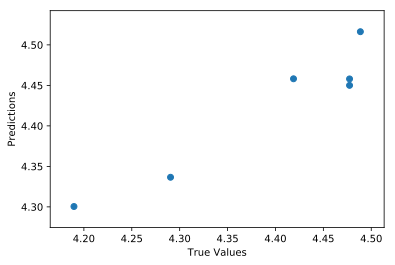

In [82]:
plt.scatter(y_test, predictions);
plt.xlabel('True Values')
plt.ylabel('Predictions')

In [83]:
model.score(X_test, y_test)

0.7649270069721698

# Use K-folds Cross Validation

In [ ]:
from sklearn.cross_validation import cross_val_score
# 10-fold cross-validation
reg = LinearRegression()
scores = cross_val_score(reg, X, y, cv=10, scoring='mean_squared_error')

# scores output is negative, a sklearn quirk bc mse is used to min. optimization func.
print(-scores)

In [84]:
from sklearn.cross_validation import cross_val_score
# 10-fold cross-validation
reg = LinearRegression()
scores = cross_val_score(reg, X, y, cv=10, scoring='mean_squared_error')

# scores output is negative, a sklearn quirk bc mse is used to min. optimization func.
print(-scores)

[0.00386847 0.00029413 0.00338381 0.00356728 0.01796063 0.00346785
 0.02465545 0.0047984  0.00286864 0.00396485]


/Users/cyrusrustomji/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/cyrusrustomji/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/cyrusrustomji/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/cyrusrustomji/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.

In [89]:
df.head()

,artist,followers,popularity,followers_log,popularity_log
0,Kendrick Lamar,8813295,94,15.991772,4.543295
0,Travis Scott,2627425,90,14.781515,4.499810
0,Migos,5268541,91,15.477264,4.510860
0,Jaden Smith,379461,74,12.846507,4.304065
0,Rich Brian,622901,74,13.342143,4.304065


In [90]:
X = df.drop(['artist','followers','popularity','popularity_log'],axis=1)
y = df['followers_log']

In [94]:
X.head()

,popularity_log
0,4.543295
0,4.499810
0,4.510860
0,4.304065
0,4.304065


In [95]:
# cross validation test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(46, 1) (46,)
(6, 1) (6,)


In [96]:
lm = linear_model.LinearRegression()
model = lm.fit(X_train, y_train)
predictions2 = lm.predict(X_test)

In [97]:
predictions2

array([4.44265126, 4.35670883, 4.34380542, 4.34380542, 4.4543473 ,
       4.53259949])

Text(0,0.5,'Predictions')

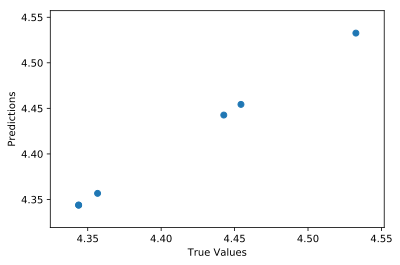

In [98]:
plt.scatter(y_test, predictions2)
plt.xlabel('True Values')
plt.ylabel('Predictions')

In [100]:
model.score(X_test, y_test)

1.0

In [101]:
# Elastic Net

from sklearn.linear_model import ElasticNet
from sklearn.linear_model import ElasticNetCV
alpha = 1e-5
enet = ElasticNet(alpha=alpha)
y_pred_enet = enet.fit(X_test, y_test)
y_pred_enet.score(X_test,y_test)

0.9999959090188416

In [102]:
model.coef_

array([1.])

In [105]:
y_test.head()

0    4.442651
0    4.356709
0    4.343805
0    4.343805
0    4.454347
Name: popularity_log, dtype: float64

In [106]:
preds = model.predict(X_test)
rmse = np.sqrt(MSE(y_test, predictions))
rmse

0.09890836193982405

In [107]:
r2_training = model.score(X_train, y_train)
r2_training

1.0

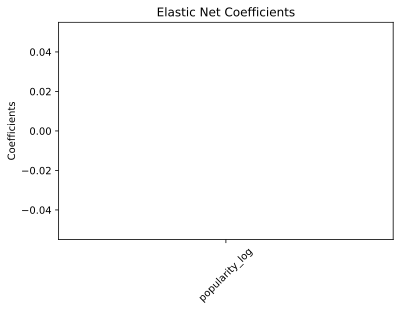

<Figure size 432x288 with 0 Axes>

In [114]:
# graphs coefficients of lassos

lasso = Lasso(alpha=1e-2)
lasso_coef = lasso.fit(X_test, y_test).coef_
_ = plt.bar(range(len(X_test.columns)), lasso_coef)
_ = plt.xticks(range(len(X_test.columns)), X_test.columns, rotation=45)
_ = plt.ylabel('Coefficients')
_ = plt.title('Elastic Net Coefficients')
plt.show()
lasso.score(X_test,y_test)
plt.savefig('coefficients.png')

In [115]:
model.coef_

array([1.])

# Poly Fit

# Gradient Descent

# KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors=5) model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)

# search for an optimal value of K for KNN
k_range = list(range(1, 31))
k_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X, y, cv=10, scoring='accuracy')
    k_scores.append(scores.mean())
print(k_scores)

# plot the value of K for KNN (x-axis) versus the cross-validated accuracy (y-axis)
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')

# Logistic Regression

In [116]:
from sklearn.linear_model import LogisticRegression

# Support Vector Machines

In [ ]:
from sklearn import svm

svc = svm.SVC(kernel = 'poly',degree = 3)
svc = svm.SVC(kernel = 'rbf')

svc.fit(X_train, y_train)
y_pred = model_svm.predict(X_test)
accuracy_score(y_test,y_pred)



#Run a GridSearchCV with different C and gamma

# Decision Trees

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier #even more randomized- split rule is random

decisiontree = DecisionTreeClassifier()
quick_test_afew_times(decisiontree, X, y1)

randomforest = RandomForestClassifier()
quick_test_afew_times(randomforest, X, y1)